In [1]:
from Bio import Nexus, Phylo, SeqIO
from collections import defaultdict
from io import StringIO

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

import pandas as pd
import numpy as np

import re
from pathlib import Path

from itertools import combinations
from evaluation_helpers import *

# Evaluate estimation of population size with skyline / constant coalescent prior in BEAST

In [2]:
input_csv = "../scripts/successful_combined_runs.csv" 
df = process_results(input_csv)
df.head()

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...


In [3]:
log_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.log"
log_test_path_coal = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/constcoal/expgrowth_fast/highmutsig/constcoal_homochronous_expgrowth_fast_highmutsig.T0.log"
get_median_population_size(log_test_path, burnin=0.1, mode="skyline")

(array([1552.13790108, 1200.8518131 , 2093.08881038, 1343.43884301,
        1281.56003457, 1869.28924453, 1936.6701581 , 1316.14299345,
        1517.91706262,  999.82982843]),
 array([ 867.27869803,  460.26612092,  835.15322499,  451.80365907,
         496.24839706,  999.90870578, 1152.56781268,  822.85035757,
        1045.44876102,  687.70371792]),
 array([2667.750165  , 2597.39891569, 3606.18149002, 2799.65142894,
        2488.515568  , 3099.85461082, 3085.70091968, 2081.70040376,
        2282.51468757, 1511.16445644]),
       skyline.popSize1  skyline.popSize2  skyline.popSize3  skyline.popSize4  \
 7734       1167.860548       1283.295040       1924.841063       1002.824916   
 4746       1980.399238       1798.864733       1509.313881       2056.512492   
 6593       2550.998879        413.781994       2050.349540       1156.380453   
 7462       1913.843656       1255.717375       2136.295249       1584.458333   
 3593       1057.313009       1963.022701       2317.074027       1

In [4]:
tree_test_path = "/Users/mariebecker/Documents/Uni/ETH/RotationStadler/BESP_paper-analyses/scripts/../results/pop_size_simulations/simulation_results/homochronous_independent/skyline/expgrowth_fast/highmutsig/skyline_homochronous_expgrowth_fast_highmutsig.T0.tree"
tree_test = Phylo.read(tree_test_path, "nexus")

In [5]:
get_skyline_group_boundaries(tree_test, num_groups=10)

[1.5031879938469501,
 2.825459449616119,
 6.2356139000062285,
 8.879562994976823,
 12.4962551931485,
 18.935906881068377,
 32.73432499026467,
 52.81856882193597,
 113.41847337937043,
 795.4148294613499]

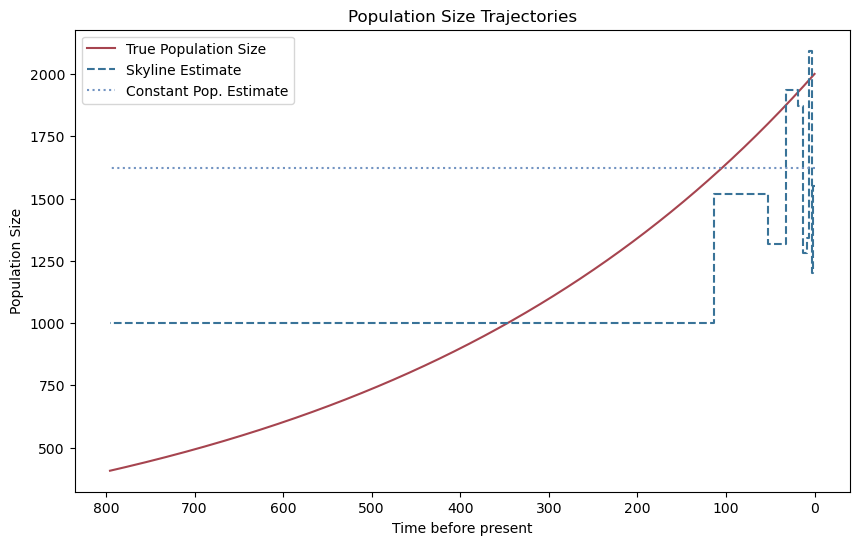

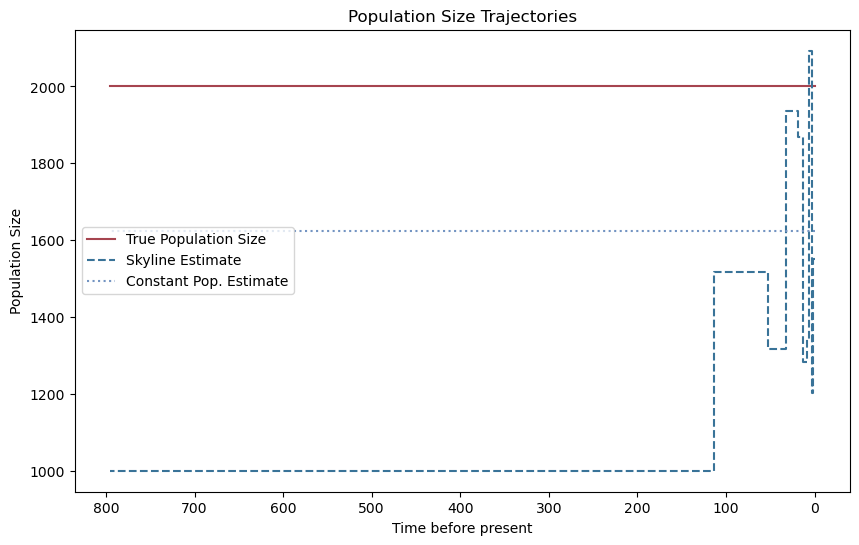

In [6]:
def plot_population_trajectories(skyline_times, skyline_medians, constant_pop_estimate, present_pop_size, growth_rate = None):
    """
    Plots:
    - Exponential population growth (true)
    - Stepwise skyline population size estimates
    - Constant population estimate (overall median)
    
    Parameters:
        skyline_times (list): End time points of skyline intervals (backward in time, ascending).
        skyline_medians (list): Median population sizes for each interval.
        present_pop_size (float): True present-day population size (N0).
        growth_rate (float): Exponential growth rate (r).
        constant_pop_estimate (float): Overall median population size.
    """
    root_height = skyline_times[-1]  # The last time point is the root height (earliest time)

    # True exponential function (from root to present, i.e., from T to 0)
    t_vals = np.linspace(0, root_height, 1000)
    N_true = present_pop_size * np.exp(-growth_rate * t_vals)

    # Stepwise skyline values
    skyline_start_times = [0.0] + skyline_times[:-1]
    skyline_end_times = skyline_times
    step_times = []
    step_values = []

    for start, end, value in zip(skyline_start_times, skyline_end_times, skyline_medians):
        step_times.extend([start, end])
        step_values.extend([value, value])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(t_vals, N_true, label="True Population Size", color = '#a6444f')
    plt.plot(step_times, step_values, drawstyle='steps-post', label="Skyline Estimate", linestyle = "--", color = "#397398")
    plt.hlines(constant_pop_estimate, 0, root_height, color='#7394c2', linestyle=':', label="Constant Pop. Estimate")

    plt.xlabel("Time before present")
    plt.ylabel("Population Size")
    plt.title("Population Size Trajectories")
    plt.legend()
    plt.gca().invert_xaxis()  # show present (0) on the right
    plt.show()


skyline_times = get_skyline_group_boundaries(tree_test, num_groups=10)
skyline_medians, _, _,_ = get_median_population_size(log_test_path, burnin=0.1, mode="skyline")
coalescent_median, _, _,_ = get_median_population_size(log_test_path_coal, burnin=0.1, mode="constcoal")

plot_population_trajectories(skyline_times, skyline_medians, 
                             present_pop_size=2000, growth_rate=0.002, 
                             constant_pop_estimate=coalescent_median)

plot_population_trajectories(skyline_times, skyline_medians, 
                             present_pop_size=2000, growth_rate=0, 
                             constant_pop_estimate=coalescent_median)


In [7]:
#df_ = df.dropna()
#df_ = add_tree_information(df_)
df_ = pd.read_pickle("../results/pop_size_simulations/evaluation/tree_information_combined.pkl")
# 2min 15s

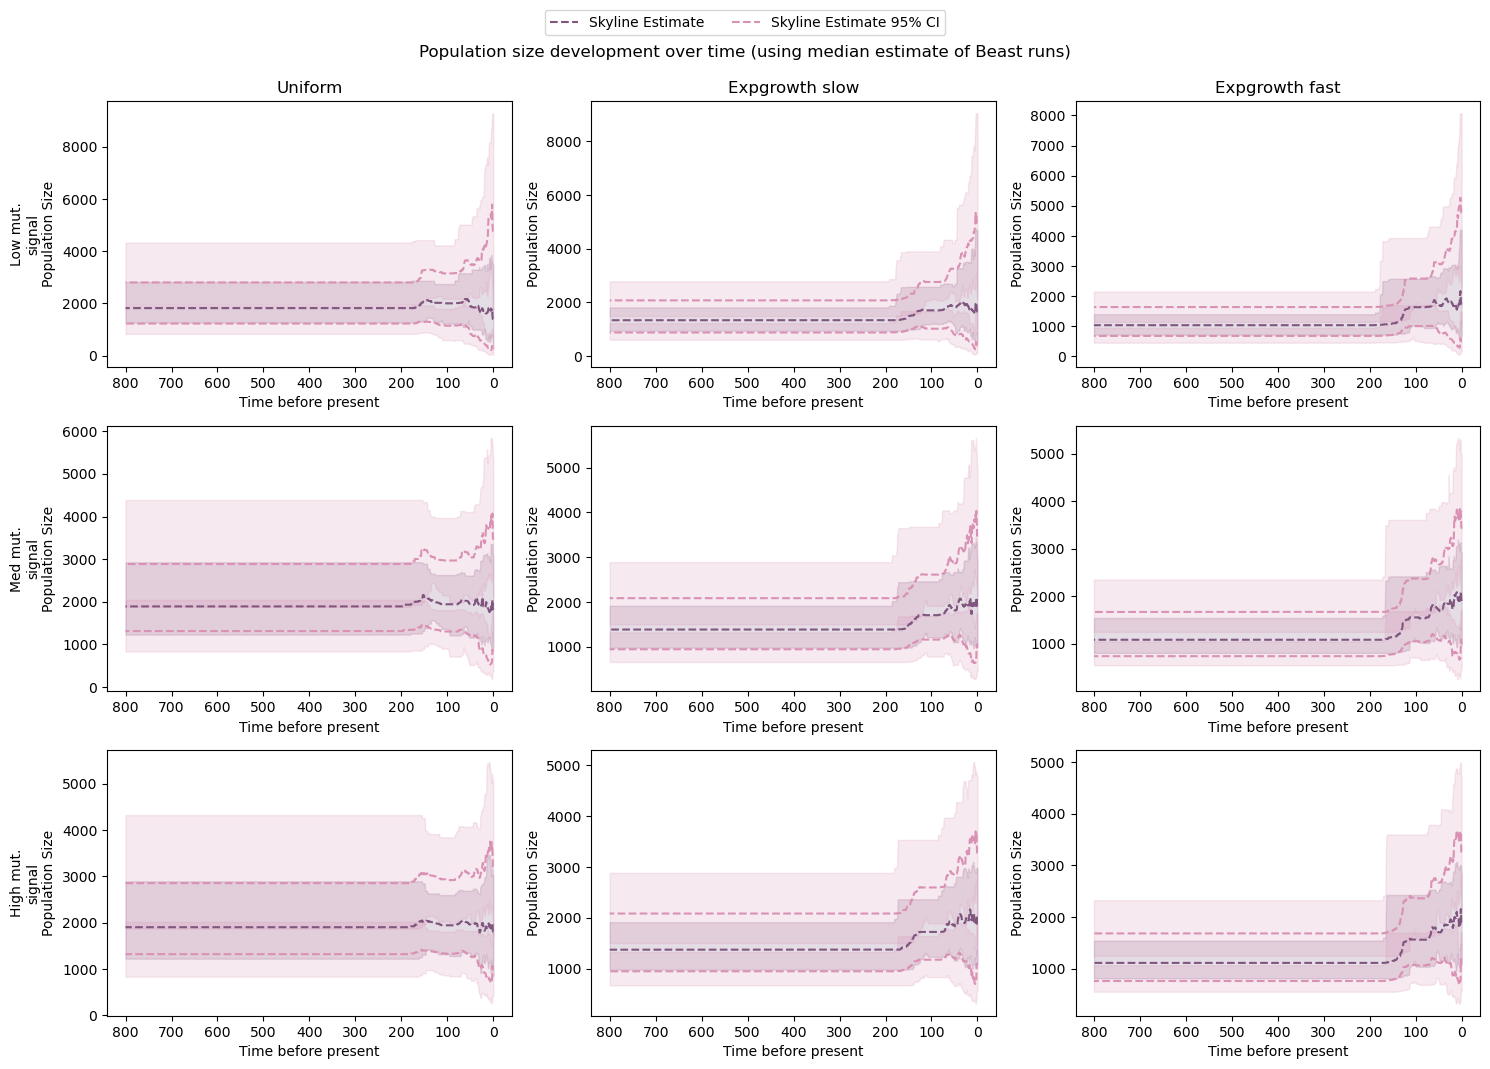

In [8]:
plot_population_summary_95cf(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)', mode = 'skyline', plot_true_size=False)

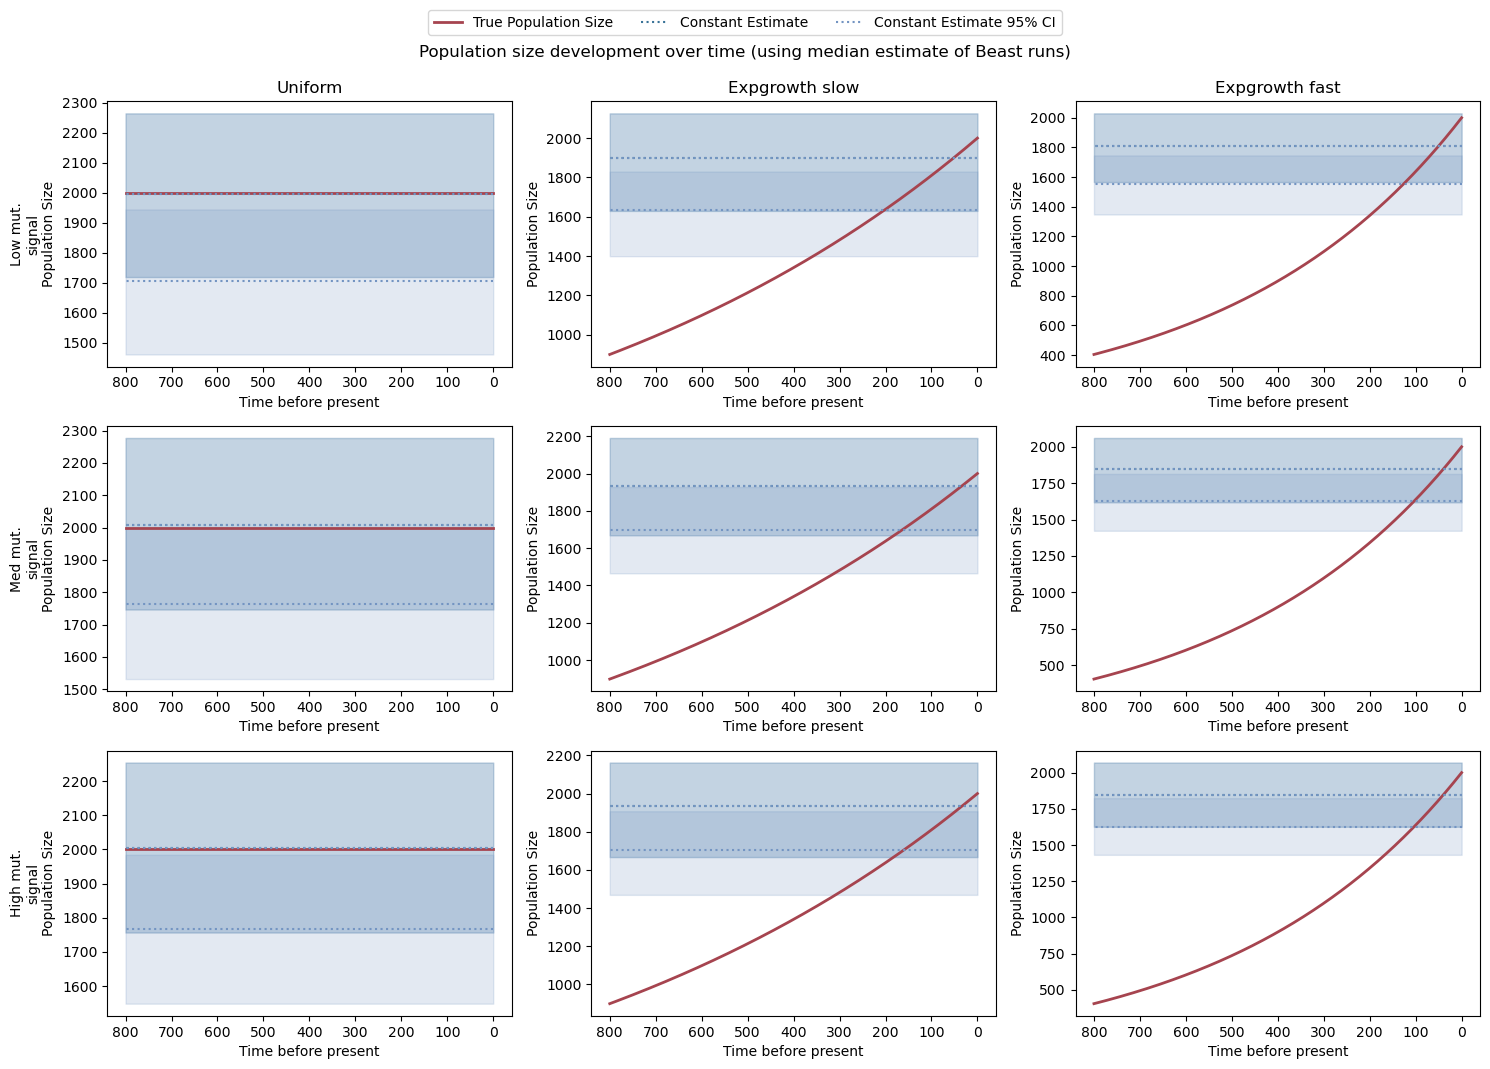

In [9]:
plot_population_summary_95cf(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)', mode = 'constcoal', plot_true_size=True)

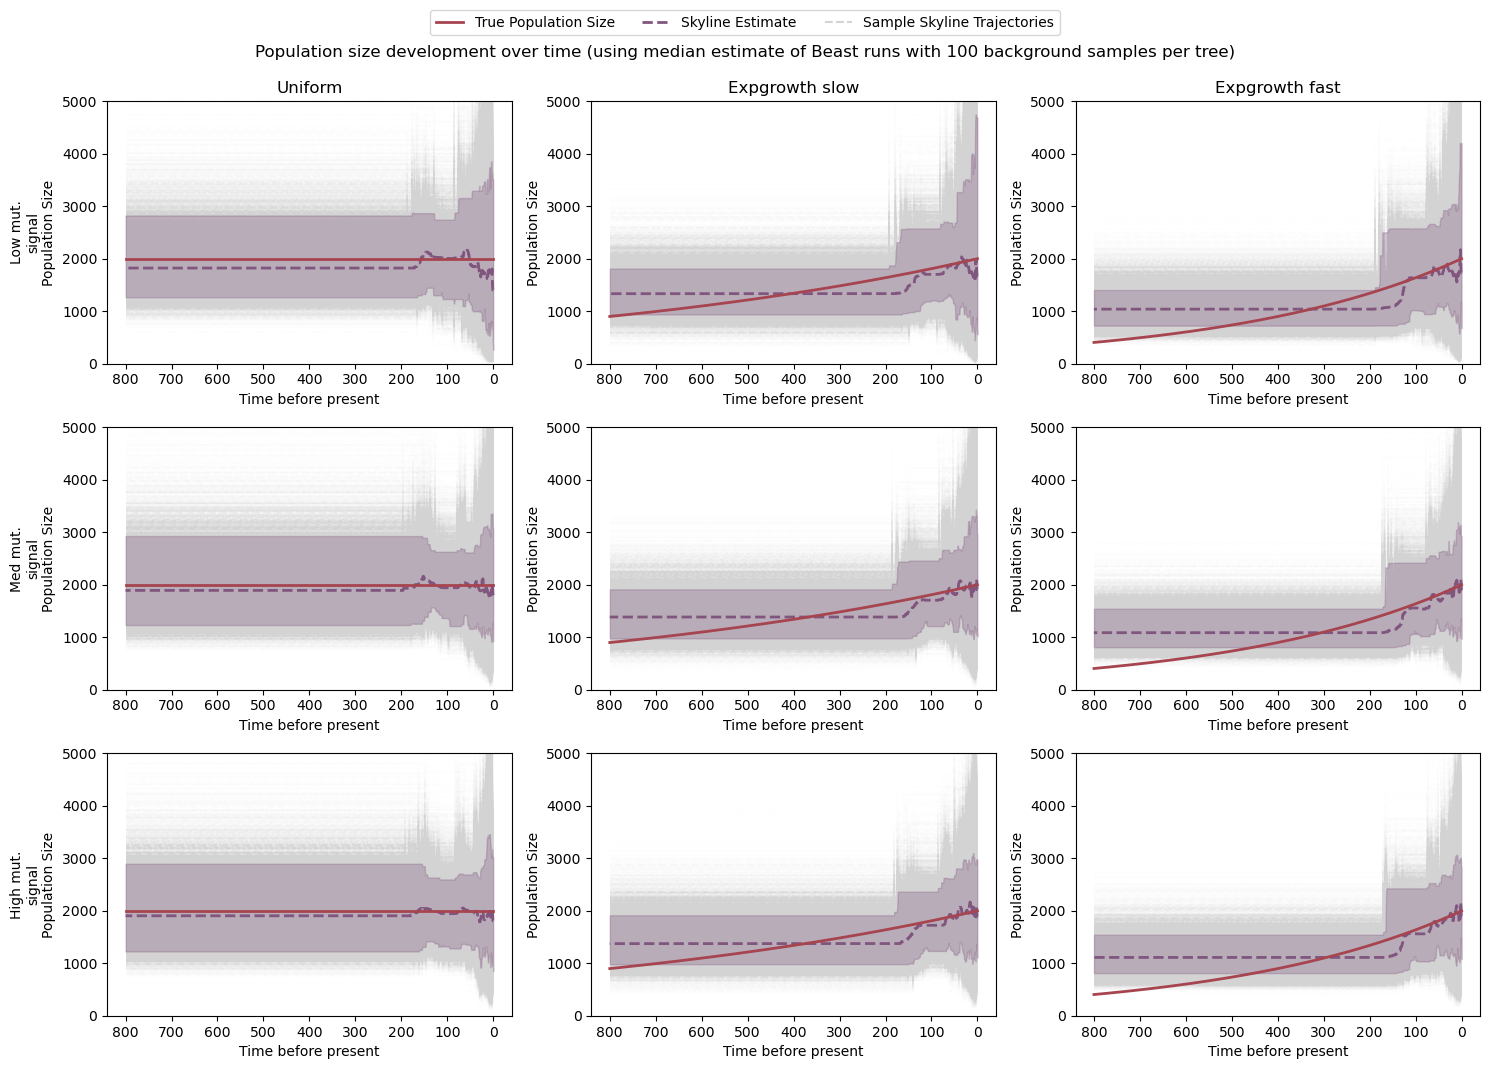

In [10]:
plot_population_summary(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs with 100 background samples per tree)', y_range = (0,5000), add_samples=True, mode = 'skyline')

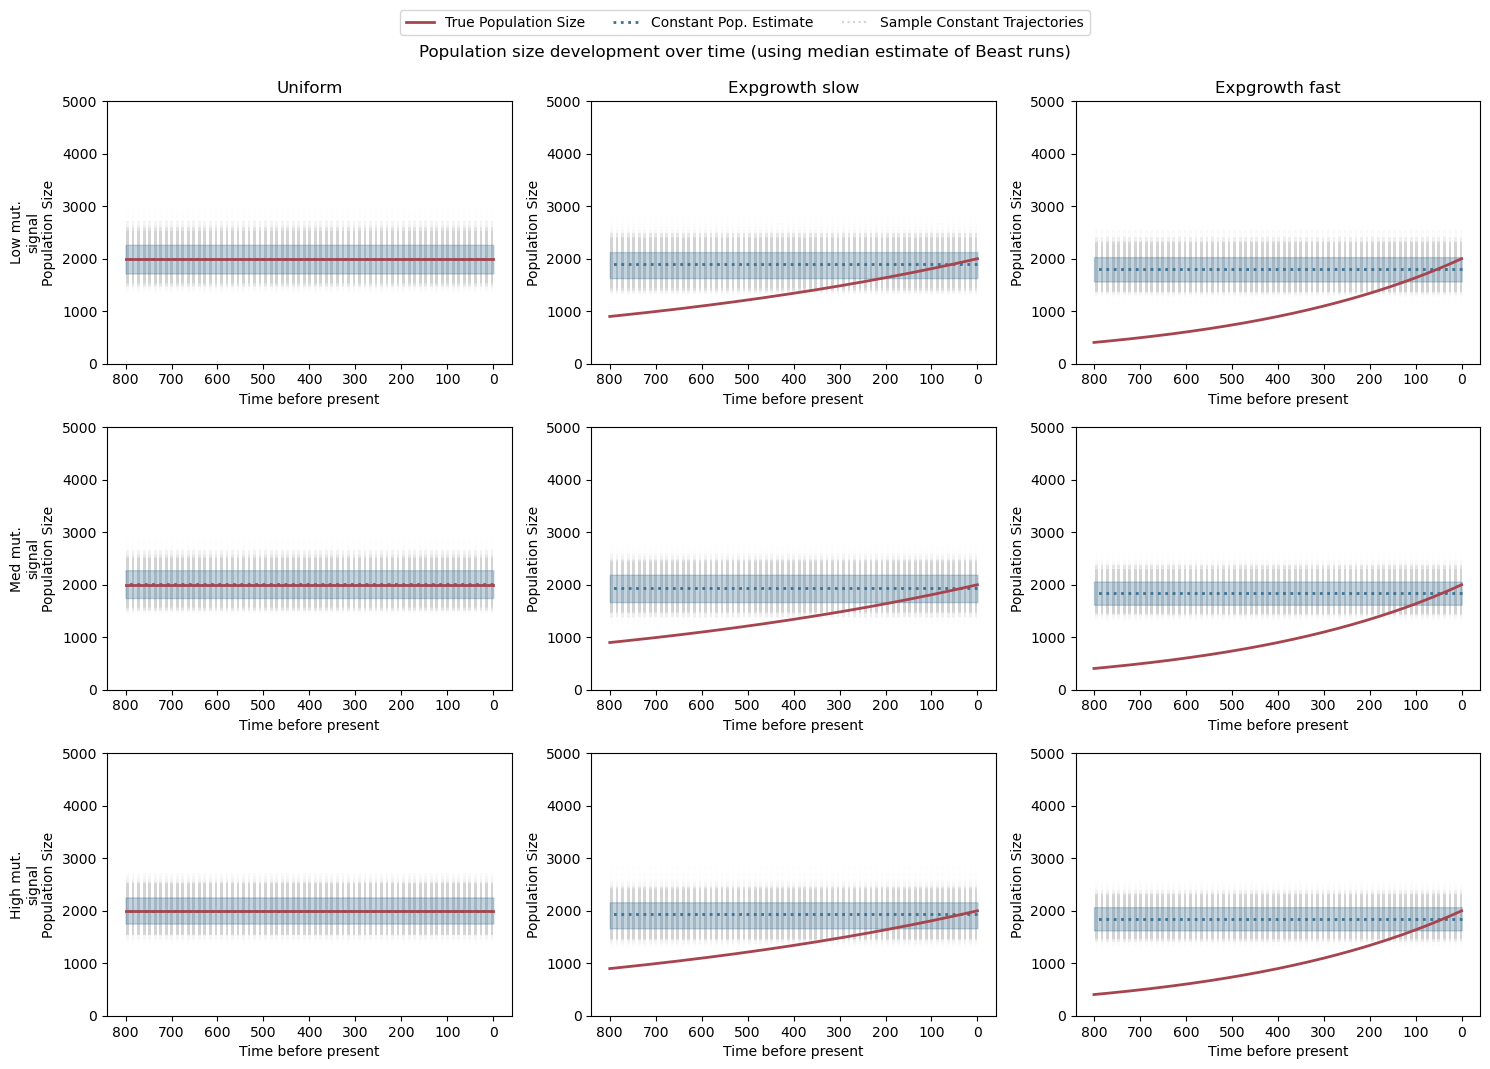

In [11]:
plot_population_summary(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)', y_range = (0,5000), add_samples=True, mode = 'constcoal')

In [ ]:
plot_population_summary(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)', y_range = (0,5000), add_samples=True, mode = 'both')

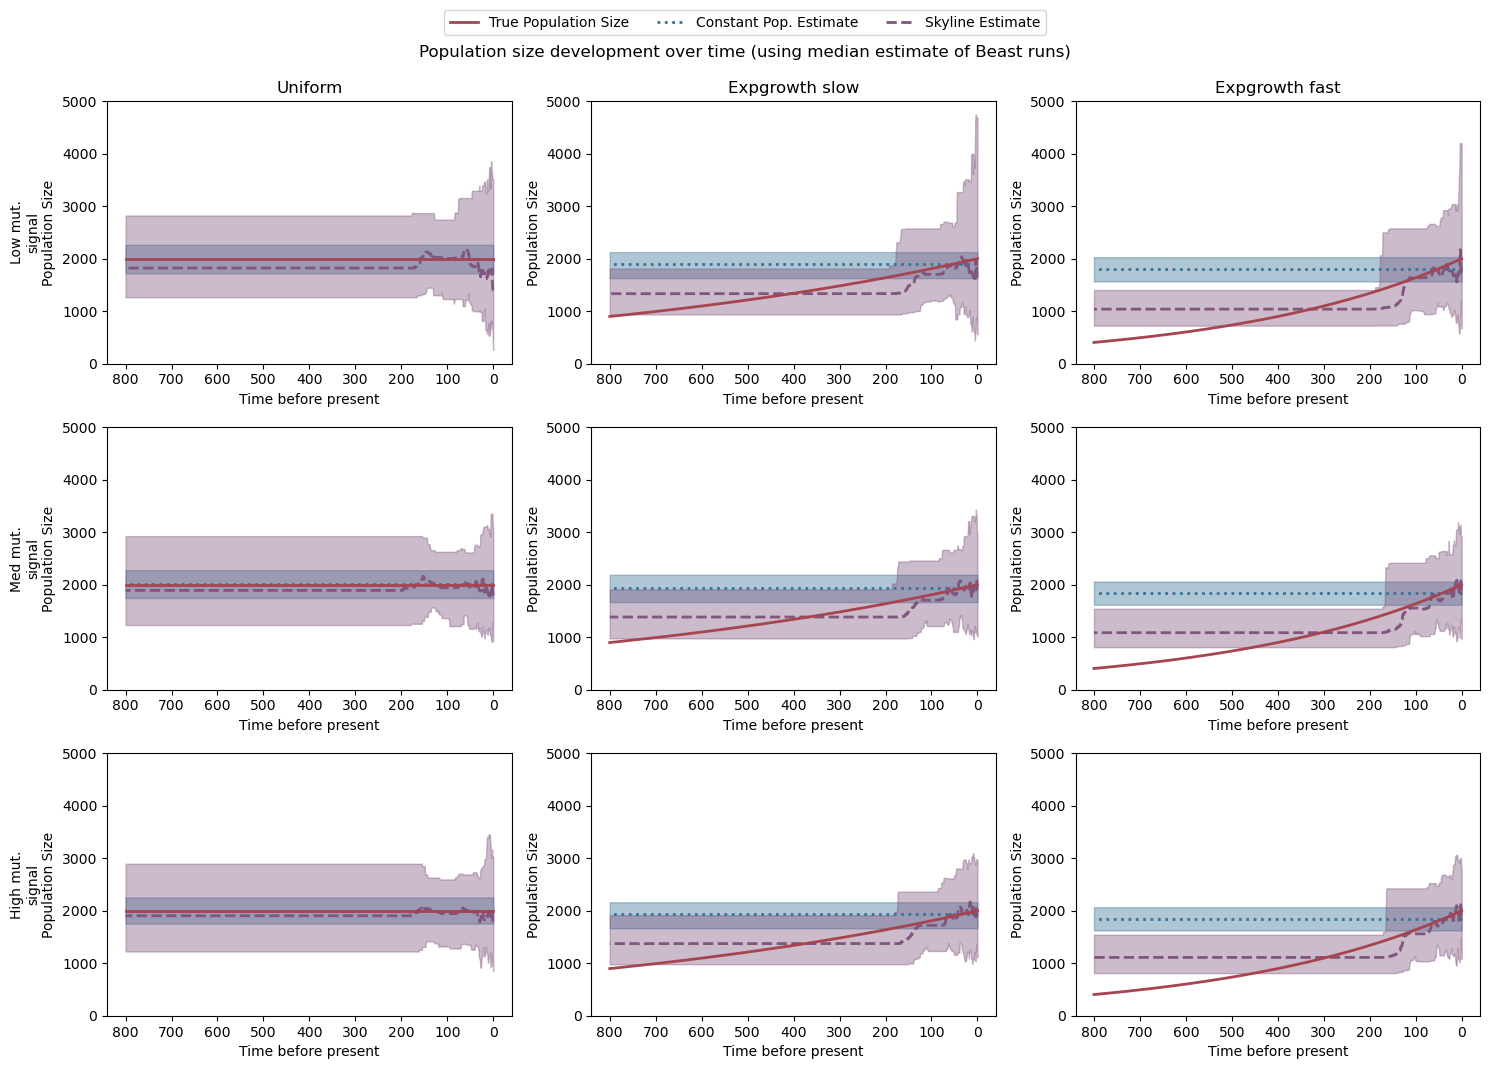

In [ ]:
plot_population_summary(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)', y_range = (0,5000), add_samples=False, mode = 'both')

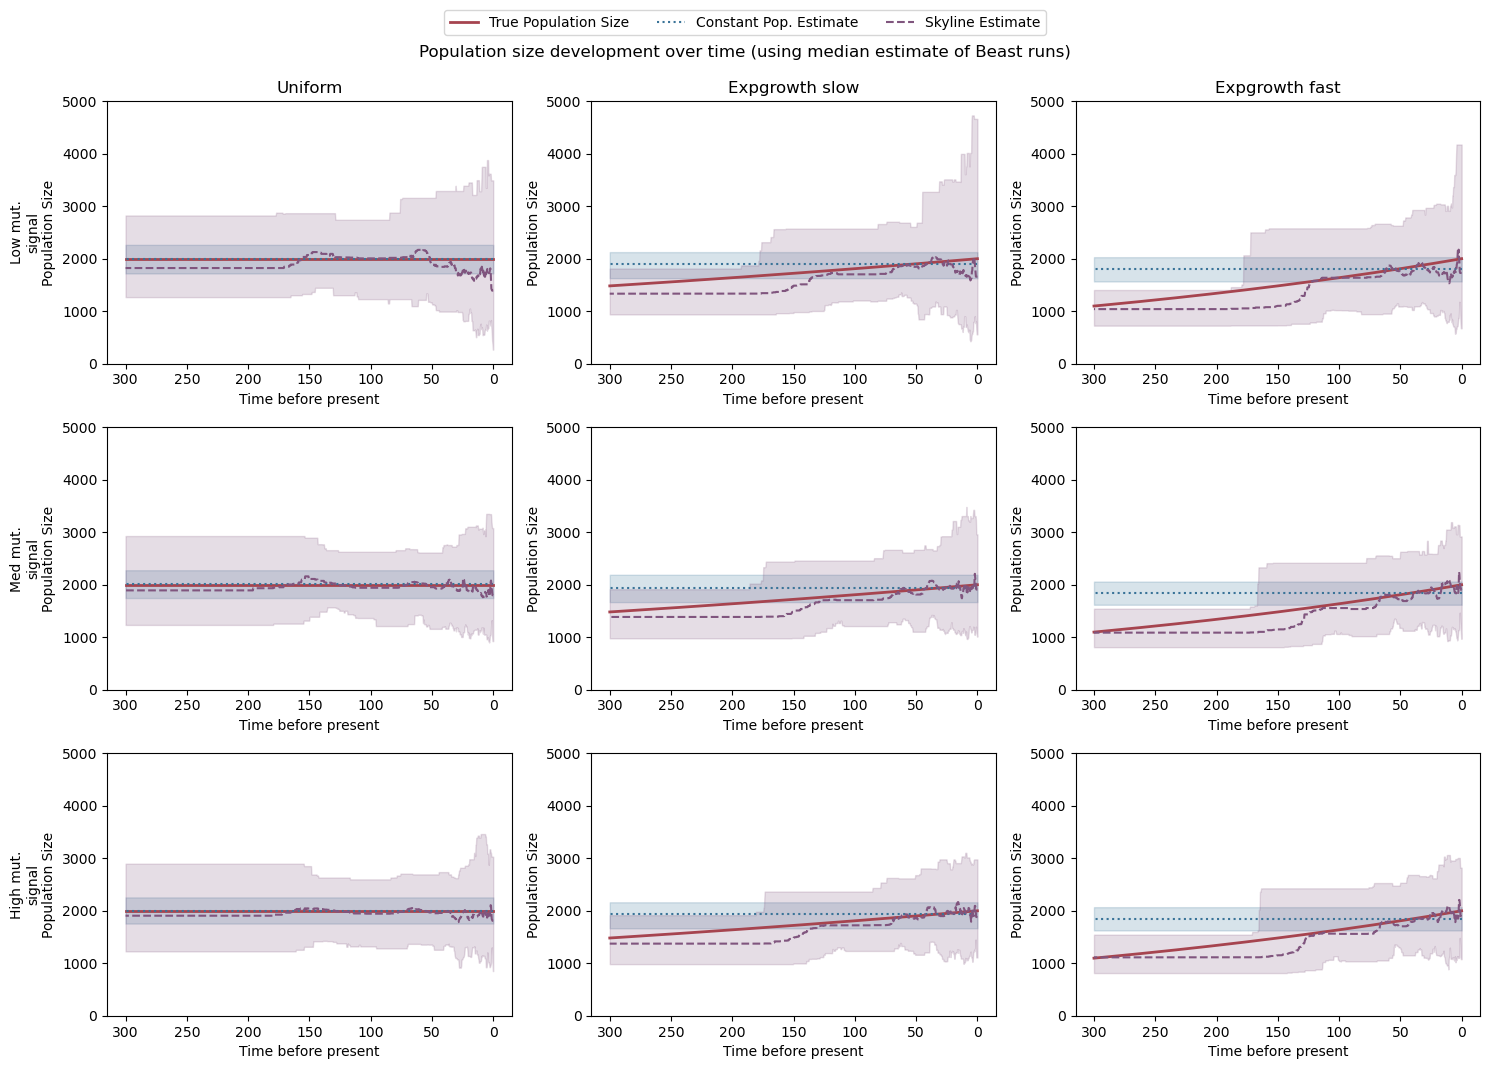

In [ ]:
# TODO: make sure that negative errors are nowhere filtered out wrongly
plot_population_summary(df_, time_horizon=300, title = 'Population size development over time (using median estimate of Beast runs)', y_range = (0, 5000))

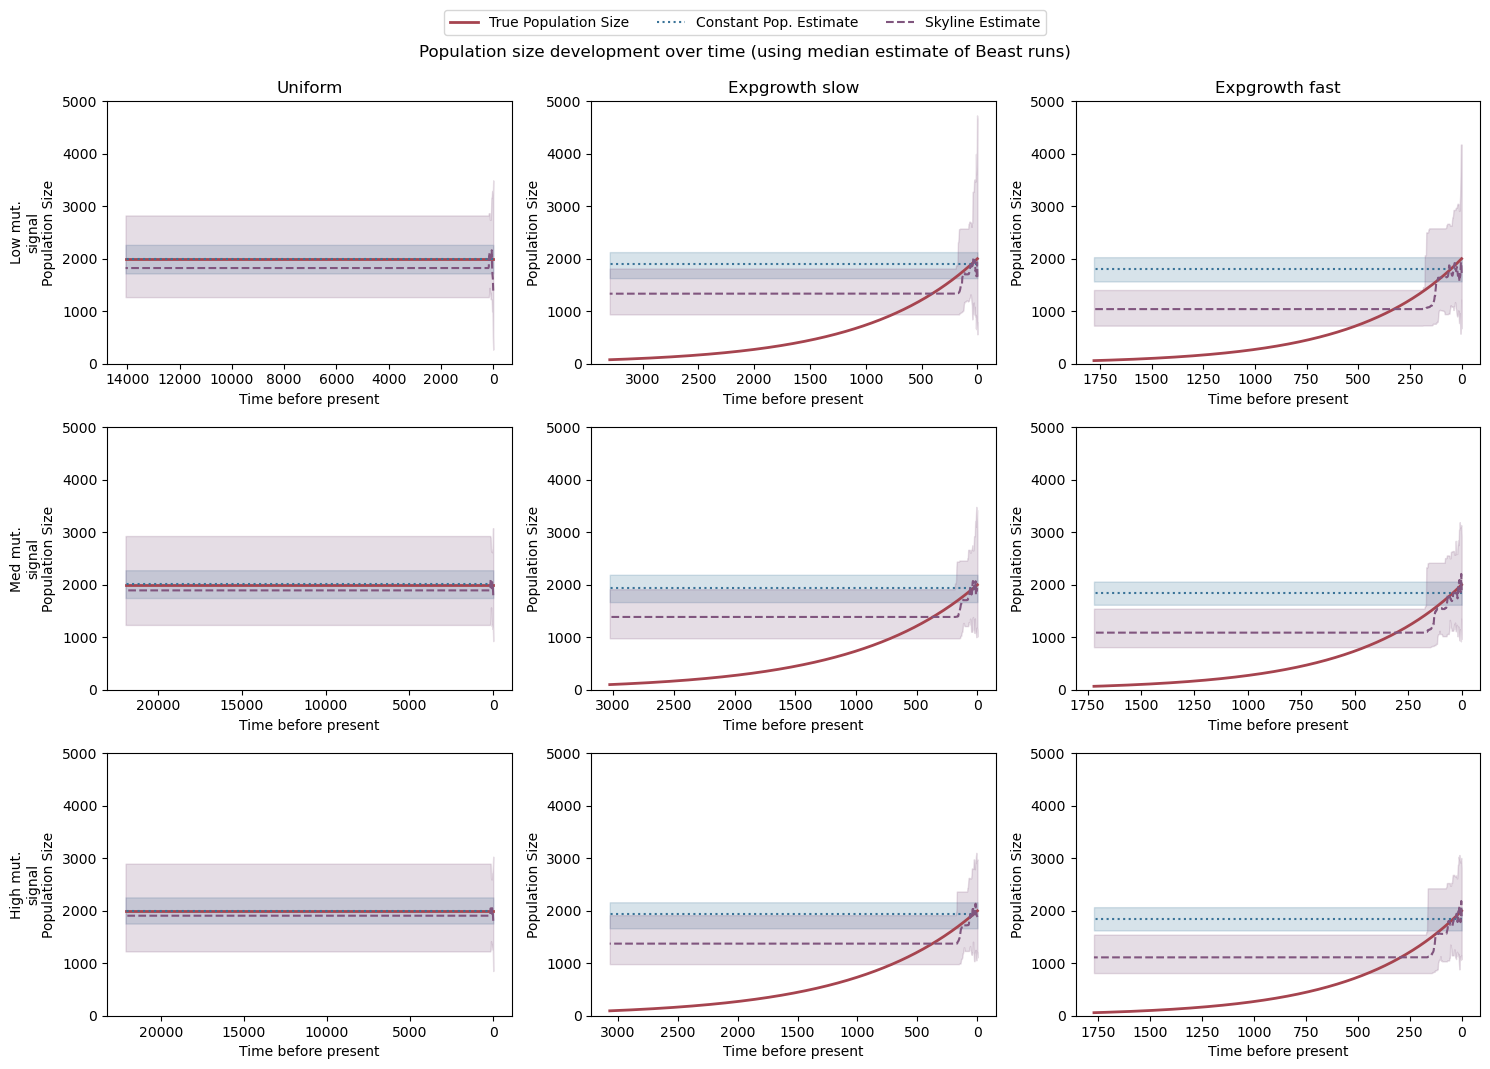

In [ ]:
plot_population_summary(df_, time_horizon=0, title = 'Population size development over time (using median estimate of Beast runs)', y_range = (0, 5000))

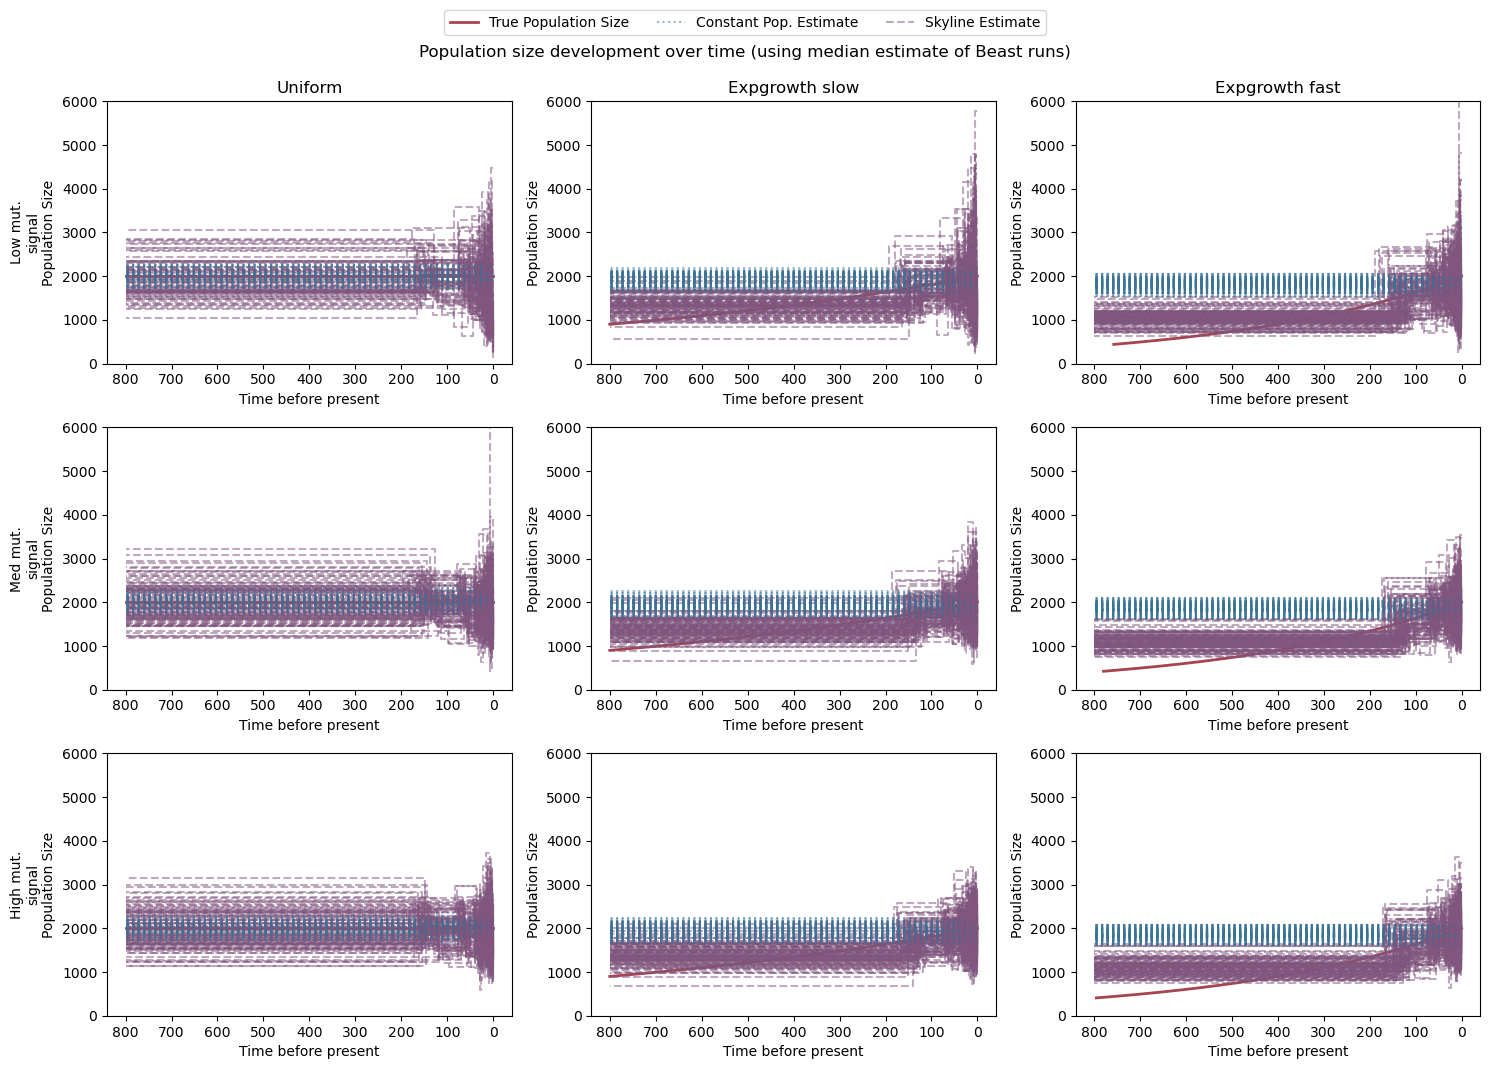

In [ ]:
plot_summary_population_grid(df_, time_horizon=800, title = 'Population size development over time (using median estimate of Beast runs)')

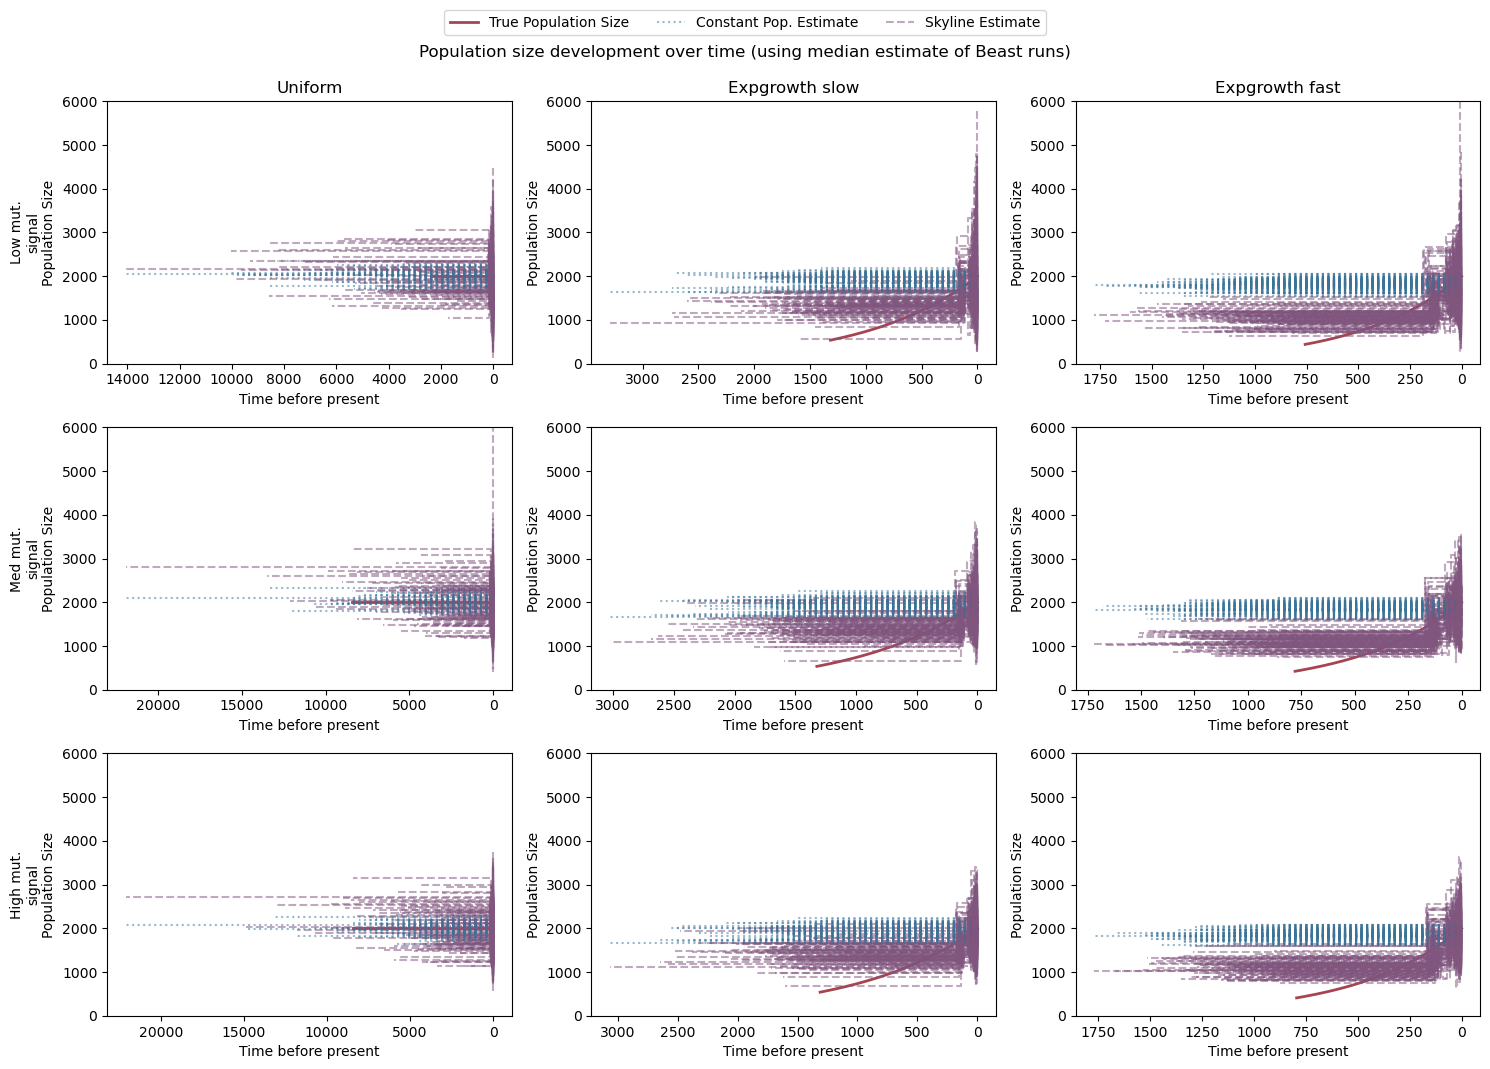

In [ ]:
plot_summary_population_grid(df_, time_horizon=0, title = 'Population size development over time (using median estimate of Beast runs)')

## Evaluate error in population size

In [ ]:
df_.head()

,population_model,mutation_signal,tree_index,sim_tree_path,present_pop_size,growth_rate,log_path_constcoal,log_path_skyline,tree_path_constcoal,tree_path_skyline,skyline_medians,skyline_times,skyline_cumulative_medians,coalescent_median,root_height,skyline_lowers,skyline_uppers,coalescent_lower,coalescent_upper
0,expgrowth_fast,high,0,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1547.7296725227638, 1220.574603056199, 2075.2...","[1.4832670227478957, 2.849745797098876, 6.1832...","[0.0, 1.4832670227478957, 2.849745797098876, 6...",1624.200550,794.919656,"[872.1746025590722, 473.3490487575755, 823.709...","[2671.6332245294357, 2623.0906564463476, 3588....",1429.809927,1854.616909
1,expgrowth_fast,high,1,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2607.979760628539, 2146.30727994675, 2318.303...","[2.465288285616907, 4.862855300430738, 8.37882...","[0.0, 2.465288285616907, 4.862855300430738, 8....",1959.951329,963.711806,"[1580.5390409179092, 868.7399518818622, 932.03...","[4323.257444251841, 4048.521281466761, 4208.07...",1731.079794,2238.897755
2,expgrowth_fast,high,2,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[2665.679199828004, 1349.0774456619902, 1506.7...","[2.4323729365631834, 4.322162318685173, 6.0568...","[0.0, 2.4323729365631834, 4.322162318685173, 6...",1995.876192,809.895041,"[1648.875832914838, 468.84999082742377, 651.95...","[4352.144889844933, 2801.6536055830734, 2844.7...",1762.503271,2274.993860
3,expgrowth_fast,high,3,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1800.714397058875, 1863.3626800442119, 2336.5...","[1.6896157304950066, 3.936925265910986, 7.1901...","[0.0, 1.6896157304950066, 3.936925265910986, 7...",1901.136871,1669.576723,"[1040.1404981590515, 780.4120716388991, 904.54...","[3091.7091706913507, 3554.4397731852964, 4131....",1676.013911,2175.057338
4,expgrowth_fast,high,4,/Users/mariebecker/Documents/Uni/ETH/RotationS...,2000,0.002,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,/Users/mariebecker/Documents/Uni/ETH/RotationS...,"[1682.238599283858, 1678.4669579213446, 2243.1...","[1.5672188278592785, 3.0836577879958895, 7.112...","[0.0, 1.5672188278592785, 3.0836577879958895, ...",1707.205823,893.885324,"[956.9153323832619, 687.1211469537732, 945.881...","[2887.1628995054116, 3165.8567761816093, 3876....",1502.201054,1947.793989


In [ ]:
df_.skyline_times[0]

[1.4832670227478957,
 2.849745797098876,
 6.183249974401292,
 8.809766528570094,
 12.524234549634912,
 18.938082541085123,
 32.7436207081588,
 52.78846566238792,
 113.23975892592398,
 794.9196555560216]

In [ ]:
def calculate_population_size_cumulative_error(t, present_pop_size, growth_rate,
                                               skyline_times = None, skyline_cumulative_medians = None, skyline_medians = None,
                                               coalescent_median = None):
    cum_pop_size_sim = cumulative_exp_pop_size(t, present_pop_size, growth_rate)

    if coalescent_median is not None:
        cum_pop_size_est = coalescent_median * t
    
    elif skyline_times is not None and skyline_cumulative_medians is not None:
        interval_index = np.searchsorted(skyline_times, t, side="left") - 1
        skyline_start_times = [0] * skyline_times
        cum_pop_size_est = skyline_cumulative_medians[interval_index] + skyline_medians[interval_index] * (t - skyline_start_times[interval_index])

    cumulative_pop_size_error = cum_pop_size_est - cum_pop_size_sim

    return {
        "cum_pop_size_sim": cum_pop_size_sim,
        "cum_pop_size_est": cum_pop_size_est,
        "cum_pop_size_error": cumulative_pop_size_error,
    }


In [ ]:
def calculate_population_size_error(
    t,
    present_pop_size,
    growth_rate,
    skyline_times=None,
    skyline_medians=None,
    coalescent_median=None
):
    # 1. True population size at time t
    true_pop_size = present_pop_size * np.exp(-growth_rate * t)

    # 2. Estimated population size
    if coalescent_median is not None:
        est_pop_size = coalescent_median

    elif skyline_times is not None and skyline_medians is not None:

        # Use np.searchsorted to find the correct interval index
        interval_index = np.searchsorted(skyline_times, t, side="left") - 1
        est_pop_size = skyline_medians[interval_index]

    else:
        raise ValueError("Either coalescent_median or skyline_times + skyline_median must be provided.")

    # 3. Compute errors
    error = (est_pop_size - true_pop_size)
    relative_error = error / true_pop_size
    abs_relative_error = abs(relative_error)

    return {
        "true_pop_size": true_pop_size,
        "est_pop_size": est_pop_size,
        "diff_pop_size": error,
        "abs_diff_pop_size": np.abs(error),
        "rel_diff_pop_size": relative_error,
        "abs_rel_diff_pop_size": abs_relative_error
    }

In [ ]:
def add_population_size_errors(node_df, tree_df):
    # First, rename columns to prepare for merge (avoid name clashes)
    tree_df_renamed = tree_df.rename(columns={
        "mutation_signal": "mutsig",
        "population_model": "growth_model"
    })

    # Merge node_df with tree_df to bring in matching tree metadata
    merged_df = node_df.merge(
        tree_df_renamed,
        on=["tree_index", "mutsig", "growth_model"],
        how="left",
        suffixes=("", "_tree")
    )

    # Apply row-wise error calculation
    error_df = merged_df.apply(
        lambda row: pd.Series(
            calculate_population_size_error(
                t=row["height_sim"],
                present_pop_size=row["present_pop_size"],
                growth_rate=row["growth_rate"],
                coalescent_median=row["coalescent_median"] if row["model"] == "constcoal" else None,
                skyline_times=row["skyline_times"] if row["model"] == "skyline" else None,
                skyline_medians=row["skyline_medians"] if row["model"] == "skyline" else None
            )
        ),
        axis=1
    )

    # Combine original dataframe with the new columns
    merged_df = pd.concat([merged_df, error_df], axis=1)
    return merged_df